# Model sensitivity and uncertainty

## Objectives
- Apply model calibration and evaluation techniques to corn biomass prediction models based on simplified RUE and GDD approaches
- Learn and apply parameter sensitivity analysis methods: Local (gradient-based), Morris (screening), and Sobol (variance decomposition)

## Readings

- (optional) Razavi S, Jakeman A, Saltelli A, Prieur C, Iooss B, Borgonovo E, Plischke E, Lo Piano S, Iwanaga T, Becker W, et al. 2021. The Future of Sensitivity Analysis: An essential discipline for systems modeling and policy support. Environmental Modelling & Software 137: 104954 (<https://www.sciencedirect.com/science/article/pii/S1364815220310112>)

## Introduction
First we will continue from the last section on model calibration and evaluation. We will work with a corn biomass prediction model based on a abbreviated Radiation Use Efficiency (RUE). The goal is to improve the logistic model respond to bioclimatic variables like solar radiation as a driving variable. We then calibrate the model parameters to improve prediction accuracy and evaluate the model's performance using various metrics. 

Next, we will perform a sensitivity analysis to understand the influence of different parameters on the model's output. We will use the original logistic growth model for simplicity. But the same methods can be applied to the RUE-based model and other more complex models as well. 

This is a good time to think about some analogies between modeling and cooking. In cooking, you have a recipe that outlines the ingredients and steps needed to prepare a dish. Similarly, in modeling, you have a set of equations and parameters that define how the model behaves. Just as you might adjust the amount of salt or spice in a recipe to suit your taste, you can adjust model parameters to improve its performance. The final dish's taste can be likened to the model's output, which we want to be as accurate and reliable as possible.

As you get better with cooking, you will learn to appreciate the influence of each ingredient on the final dish. Similarly, in modeling, sensitivity analysis helps us understand how changes in model parameters affect the output, allowing us to identify which parameters are most critical to the model's performance. The influence of an ingredient may be subdued or amplified by other ingredients, just as the effect of a parameter may depend on the values of other parameters in the model. These interactions of parameters can be complex, and sensitivity analysis helps us navigate this complexity through local and global sensitivity analyses.

### Approach to sensitivity analysis

In this notebook, we explore three sensitivity analysis methods in a deliberate progression:

1. **Local Sensitivity Analysis** - We begin with the simplest approach: examining how small perturbations of one parameter at a time affect model output at a single point. This requires only k+1 model evaluations (where k is the number of parameters), making it the fastest method. It's ideal for initial exploration and understanding local parameter behavior. This is similar to what we did in the previous section when we looked at parameter gradients during calibration. Chapter 1 of @Thornley2000 describes this approach well.

2. **Morris Method (Elementary Effects)** - Next, we introduce a screening technique that explores the entire parameter space through multiple random trajectories. With r(k+1) evaluations, it's more computationally intensive than local analysis but still efficient enough for screening many parameters. Morris provides our first glimpse of parameter interactions and non-linearities across the parameter space. `r` is the number of trajectories, which you can adjust based on your computational budget and desired accuracy. The Morris method is particularly useful when dealing with a large number of parameters, as it helps identify the most influential ones without requiring exhaustive sampling of the entire parameter space. 

3. **Sobol Method (Variance Decomposition)** - Finally, we employ the most rigorous but computationally expensive approach, requiring n×(2k+2) evaluations. Sobol quantitatively decomposes output variance into individual parameter contributions and their interactions, providing the most comprehensive sensitivity information. n is the number of samples per parameter, which you can adjust based on your computational resources and the desired precision of the sensitivity indices. This method is ideal for a deep understanding of parameter effects and interactions, especially after narrowing down to the most important parameters using Morris.

This progression mirrors a practical workflow: start with local analysis for quick insights, use Morris to screen parameters efficiently, then apply Sobol for detailed quantitative analysis of the most important parameters identified by Morris.

**Why does sensitivity matter?** Sensitivity analysis is not just an academic exercise—it's essential for:
- **Model refinement**: Identifying which parameters deserve careful measurement or calibration
- **Uncertainty quantification**: Understanding which uncertainties in parameters most affect predictions
- **Experimental design**: Prioritizing measurements of the most influential parameters
- **Model simplification**: Finding parameters that can be fixed without losing predictive power

## Setup
We will use the following packages for this notebook. Make sure to install them if you haven't already.

In [1]:
new_install = false
#if running first time, change to 'true'
if new_install
    import Pkg
    Pkg.add("GlobalSensitivity")
    Pkg.add("QuasiMonteCarlo")
    Pkg.add("Distributions")
    Pkg.add("Random")
    Pkg.add("Statistics")
    Pkg.instantiate()
    
end

In [2]:
using Cropbox, Plots
using GlobalSensitivity, DataFrames, Random, Distributions

In [3]:
using DataFramesMeta
using StatsBase
using CSV
using Dates, Cairo, Fontconfig

## About GlobalSensitivity.jl

This notebook uses the [GlobalSensitivity.jl](https://github.com/SciML/GlobalSensitivity.jl) package for Morris and Sobol sensitivity analyses. This package provides:

- **Robust implementations** of standard sensitivity analysis methods
- **Efficient sampling strategies** (Saltelli sampling for Sobol, optimized trajectories for Morris)
- **Standardized interface** compatible with the SciML ecosystem
- **Better numerical stability** than manual implementations

**Key improvements in this notebook:**
1. Morris method uses optimized trajectory generation from GlobalSensitivity.jl
2. Sobol method uses Saltelli sampling scheme for efficient variance decomposition
3. All plotting issues have been fixed with proper variable references
4. Methods are more computationally efficient and numerically stable

## ⚠️ Important: Execute Cells in Order

**This notebook must be executed from top to bottom!**

The sensitivity analysis sections build on each other:
1. **Setup & Data Loading** (Cells 1-40)
2. **Local Sensitivity** (generates `res_logistic`)
3. **Morris Method** (generates `μ_star_logistic`, `σ_logistic`, `morris_results_logistic`)
4. **Sobol Method** (generates `sobol_logistic` with `S1` and `ST`)
5. **Comparison Plots** (requires all previous results)

If you get errors like "UndefVarError", restart the kernel and run all cells from the beginning.

## Improving the maize growth model

We will continue to build on the maize growth model we developed in previous sections. 

Previously, we calibrated the logistic and Gompertz growth functions against observed biomass data from a field corn experiment. We've also examined the weather data during the period of this corn experiment at  Beltsville, MD in 2002. To refresh, seeding was done on May 15, 2002 with 8 $\mathrm{plants/m^2}$ of planting density. Plants were well-fertilized and irrigated as needed.

We load the corn biomass data first from a CSV file into a `DataFrame` using [CSV.jl](https://github.com/JuliaData/CSV.jl) package, and unitfy it. 


In [4]:
corn_data = CSV.read("./data/corn_data.csv", DataFrame) |> unitfy;

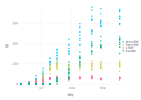

In [5]:
visualize(corn_data, :day, [:shootDW, :StemDW, :LfDW, :EarDW])

We calibrated the logistic and Gompertz functions agains above-ground biomass (`shootDW`) data over the entire growth season. We will use the logistic model as an example for this lab

### Logistic model
- Eqn.

$$
\frac{dW}{dt} = rW \cdot \left(1-\frac{W}{W_f} \right) \\
W = \frac{W_f}{1 + (\frac{W_f}{W_0} - 1) e^{-rt}}
$$

Here is the logistic growth model we're going to use for modeling biomass accumulation. 

Note that there are two ways of using exponential function in Julia. The first one is to use `exp()` function and the other is to use constant variable `ℯ` representing Euler's number with power operator `^` . To get the Unicode symbol `ℯ`, type `\euler` or first few letters like `\eu` and press tab key. `exp(-r*t)` would be equivalent to `ℯ^(-r*t)`.

- Table

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative (or specific or intrinsic) growth rate |
| $W_0$ | - | $\mathrm{g}$ | Seed mass or initial biomass |
| $W_f$ | - | $\mathrm{g}$ | Potential final mass of a plant |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

In [6]:
@system Logistic(Controller) begin
    t(context.clock.time) ~ track(u"d")
    
    r:  relative_growth_rate    ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass         ~ preserve(parameter, u"g")
    Wf: potential_final_biomass ~ preserve(parameter, u"g")

    # W(r, W, Wf): biomass => begin
    #     r * W * (Wf - W) / Wf
    # end ~ accumulate(u"g", init=W0)

    W(t, r, W0, Wf): biomass => begin
        Wf / (1 + ((Wf / W0) - 1) * ℯ^(-r*t))
    end ~ track(u"g")
end

Logistic

In [7]:
c = @config(
    :Clock => :step => 1u"d",
    )

Config for 1 system:
  Clock
    step = 1 d

In [8]:
lc = calibrate(Logistic, corn_data;
    config = c,
    index = :DAS => :t,
    target = :shootDW => :W,
    parameters = Logistic => (;
        r = (0, 0.5),
        W0 = (0, 10),
        Wf = (0, 500),
    ),
    stop = 150u"d",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 1.79 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 2800.70
Function evals per second = 2874.07
Improvements/step = 0.21100
Total function evaluations = 5132


Best candidate found: [0.0726833, 1.83683, 334.364]

Fitness: 30.599094970



Config for 1 system:
  Logistic
    r  = 0.0726833 d⁻¹
    W0 = 1.83683 g
    Wf = 334.364 g

The result of calibration is returned as a configuration object. We can use this calibrated configuration directly for `simluate()` or `visualize()`. 

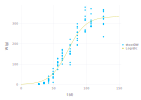

In [9]:
visualize(corn_data, Logistic, :DAS => :t, :shootDW => :W; config  = lc, stop = 150u"d", xlim = (0, 150))

We also checked the 1:1 plot with observations against model predictions.

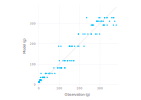

In [10]:
visualize(corn_data, Logistic, :shootDW => :W; index = :DAS => :t, config = lc, stop = 150u"d")

## Solar radiation as a driving variable 
Previously, we talked about radiation use efficiency (RUE) and thermal unit (e.g., growing degree days) approaches. Let's modify our logistic model to be a function of solar radiation and compare the behavior and performance with the time dependent model we worked on above. 

To do so, we first need to import the weather data.

:::{#nte-full-rue .callout-note}
This will be a simplified version of the RUE approach but let's also think about how to make it a more complete RUE-based model. What variables and parameters would you need to add to the model to make it a more complete RUE-based model?
:::

In [11]:
corn_weather = CSV.read("./data/corn_weather.csv", DataFrame) |> unitfy;

Reuse the `Cropbox` system we created before for growing degree days and killing degree days for daily weather data.

In [12]:
"Growing degree days and killing degree days calculator"
@system DegreeDays begin
    T:  temperature                              ~ preserve(parameter, u"°C")
    Tx: daily_max_temperature                    ~ preserve(parameter, u"°C")
    Tb: base_temperature                         ~ preserve(parameter, u"°C")
    To: optimal_temperature                      ~ preserve(parameter, u"°C")
    GDD_rating: maturity_growing_degree_rating   ~ preserve(parameter, u"K")
    
    GD(T, Tb, To): growing_degree => begin
        min(T, To) - Tb
    end ~ track(min = 0, u"K")

    GDD(GD): growing_degree_day => begin
        GD / 1u"d"
    end ~ track(u"K/d")

    cGDD(GDD): cumulative_growing_degree_day ~ accumulate(u"K")

    KD(Tx, To): killing_degree => begin
        Tx - To
    end ~ track(min = 0, u"K")

    KDD(KD): killing_degree_day => begin
        KD / 1u"d"
    end ~ track(u"K/d")

    cKDD(KDD): cumulative_killing_degree_day ~ accumulate(u"K")
end

DegreeDays

set up a configuration for `DegreeDays` system.

In [13]:
dd_config = @config (
    :Clock => (;
        step = 1u"d",
    ),
    :DegreeDays => (;
        :Tb => 10.0,
        :To => 30.0,
        :GDD_rating => 1500,
    ),
)

Config for 2 systems:
  Clock
    step = 1 d
  DegreeDays
    Tb         = 10.0
    To         = 30.0
    GDD_rating = 1500

Create a system `Weather_daily` contain and handle imported weather daily weather data. We worked with this in the previous lab. Note that in this system, we use daily average temperature as `T` for GDD calculuation, daily maximum temperature as `Tx` for KDD calculation, and `cRad` for cumulative solar radiation.

In [14]:
@system Weather_daily begin
    calendar(context)               ~      ::Calendar
    t(calendar.date)                ~ track::date

    data:                source_data     ~ provide(parameter, index = :date, init = t)
    Tavg:                avg_temperature ~ drive(from = data, by = :Tavg, u"°C")
    Tmin:                min_temperature ~ drive(from = data, by = :Tmin, u"°C")
    Tmax:                max_temperature ~ drive(from = data, by = :Tmax, u"°C")
    solrad:              solar_radiation ~ drive(from = data, by = :rad, u"MJ/m^2/d^1")
    
    T(Tavg):             temperature             => Tavg   ~ track(u"°C")
    Tx(Tmax):            daily_max_temperature   => Tmax   ~ track(u"°C")
    cRad(solrad):        sum_of_solar_radiation  => solrad ~ accumulate(u"MJ/m^2")
    
end

Weather_daily

Combine configurations for `DegreeDays`, `Logistic`, and `Weather_daily` systems.

In [15]:
c3 = @config (dd_config, lc,
    :Calendar => (
        :init => ZonedDateTime(2002, 5, 15, tz"America/New_York"),
        :last => ZonedDateTime(2002, 9, 30, tz"America/New_York"),
    ),
    :Clock => (;
        :step => 1u"d",
    ),
    :Weather_daily => (;
        :data => corn_weather, # provide a dataframe as source
    ),
)

Config for 5 systems:
  Clock
    step = 1 d
  DegreeDays
    Tb         = 10.0
    To         = 30.0
    GDD_rating = 1500
  Logistic
    r  = 0.0726833 d⁻¹
    W0 = 1.83683 g
    Wf = 334.364 g
  Calendar
    init = ZonedDateTime(2002, 5, 15, tz"America/New_York")
    last = ZonedDateTime(2002, 9, 30, tz"America/New_York")
  Weather_daily
    data = 139×10 DataFrame…

Mixin `DegreeDays` and `Weather_daily` with `Controller`.

In [16]:
@system WeatherSum(DegreeDays, Weather_daily, Controller)

WeatherSum

Run simulation of `WeatherSum` and save results to create a dataframe containing the output bioclimatic variables that include GDD variables and cumulative radiation (`cRad`)

In [17]:
corn_bioclim=select(simulate(WeatherSum; 
        config =(c3, dd_config), stop = "calendar.stop"), :t, :Tavg, :Tmin, :Tmax, :GDD, :cGDD, :KDD, :cKDD, :solrad, :cRad);

Merge `corn_data` and `corn_bioclim` dataframes by `:day` and `:t` as index and select variables needed later and put in a new datafram named `corn`. Rename the variable `:day` to `:date`. 

In [18]:
corn = leftjoin(corn_data, corn_bioclim, on = :day => :t, makeunique = true)
select!(corn, :day => :date, :DAS, :shootDW, :LA, :LfNo, :Ht, :Tavg, :GDD, :cGDD, :solrad, :cRad);

Create a logistic model with cumulative radiataion (`solad`) as driving variable. Pay attention to the units. This is a simplified version of RUE-based model without explicit RUE parameter and needing to provide LAI or fAPAR.

In [19]:
@system RadLogi(WeatherSum, Controller) begin
     r:  relative_growth_rate_rad    ~ preserve(parameter, u"g/g/(MJ/m^2)")
     W0: initial_biomass         ~ preserve(parameter, u"g")
     Wf: potential_final_biomass ~ preserve(parameter, u"g")

# differential equation
    W(r, solrad, W, Wf): biomass => begin
        (r * W * (Wf - W) / Wf)*solrad
    end ~ accumulate(u"g", init=W0)

# analytical solution
    # W(r, cRad, W0, Wf): biomass => begin
    #     Wf / (1 + ((Wf / W0) - 1) * ℯ^(-r*cRad))
    # end ~ track(u"g")
end

RadLogi

In [20]:
rlc = calibrate(RadLogi, corn;
    config = c3,
    index = :date => :t,
    target = :shootDW => :W,
    parameters = RadLogi => (;
        r = (0, 0.01), # check the unit for this parameter
        W0 = (0, 1), # check the estimate for this parameter carefully
        Wf = (300, 400),
    ),
    stop = "calendar.stop",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 4.98 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 1005.11
Function evals per second = 1027.42
Improvements/step = 0.30540
Total function evaluations = 5112


Best candidate found: [0.00405719, 1.0, 329.441]

Fitness: 29.418506175



Config for 1 system:
  RadLogi
    r  = 0.00405719 m² MJ⁻¹
    W0 = 1.0 g
    Wf = 329.441 g

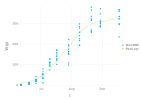

In [21]:
visualize(corn, RadLogi, :date => :t, :shootDW => :W; config = (c3, rlc), stop = "calendar.stop")

##### Did the model performance improve?
Evaluate the performance `RadLogi` model in comparison with `Logistic` model using the GOF metrics. 

##### Will the perofmance improve further if we used `GDD` as driving variable instead of `solrad`?
Think, disuss, and modify the model to run with `GDD` to test your hypothesis.

### Simple sensitivity analysis of the `RadLogi` model
We will perform a sensitivity analysis to understand how changes in model parameters affect the output of the `RadLogi` model. This will help us identify which parameters are most influential on the model's predictions.

We will first do a local sensitivity analysis by varying one parameter at a time while keeping others constant. Then, we will perform a global sensitivity analysis by varying all parameters simultaneously within their defined ranges.

In the above example, we defined the `RadLogi` model with solar radiation as the driving variable.


:::{#tip-system-zero .callout-tip}
You might have seen `:0` being used in some `Cropbox` configurations in place of the system name. In this context, `:0` is a pointer or an alias of the default system that is being used. So in this example, `:0` would be the same as `:RadLogi`.
:::

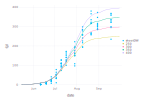

In [22]:
p = visualize(corn, :date, :shootDW;
    xlim = (Date(2002, 05, 15), Date(2002, 09, 30)),
    ylim = (0,400),
)
visualize!(p, RadLogi, :t, :W;
    config = (c3, rlc), stop = "calendar.stop",
    group = :RadLogi => :Wf => [250, 300, 350, 400],
    kind  = :line,
)

Try varying the parameters `r` and `W0` one at a time while keeping the other parameter constant. Observe how the model output changes with these variations.

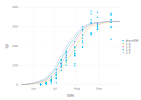

In [23]:
p = visualize(corn, :date, :shootDW;
    xlim = (Date(2002, 05, 15), Date(2002, 09, 30)),
    ylim = (0,400),

)
visualize!(p, RadLogi, :t, :W;
    config = (c3, rlc), stop = "calendar.stop",
    group = :0 => :W0 => [1.0, 1.5, 2.0, 2.5],
    kind  = :line,
)

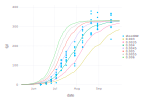

In [24]:
p = visualize(corn, :date, :shootDW;
    xlim = (Date(2002, 05, 15), Date(2002, 09, 30)),
    ylim = (0,400),
)
visualize!(p, RadLogi, :t, :W;
    config = (c3, rlc), stop = "calendar.stop",
    group = :0 => :r => 0.003:0.0005:0.006,
    kind  = :line,
)

## Sensitivity analysis
### Local sensitivity analysis
We will perform a local sensitivity analysis by varying one parameter at a time while keeping others constant. This is similar to what we just did above by examining the effect of varying `r`, `Wf` and `W0` parameters on the model output. But here we will do it more systematically looking the partial derivatives of model output with respect to each parameter at a specific point in the parameter space. We will use a small perturbation value (e.g., 1% of the parameter value) to vary each parameter and observe the change in model output.

For simplicity and interpretability, we will use the simple logistic model with days after sowing (DAS) as the driving variable instead of solar radiation or GDD. The same approach can be applied to the `RadLogi` model as well.

In [25]:
"""
    local_sensitivity_system(model_system, data; kwargs...)

Performs local sensitivity analysis by computing finite-difference derivatives of RMSE 
with respect to model parameters (r, W0, Wf).

Returns a named tuple: (baseline, baseline_rmse, sensitivities)
"""
function local_sensitivity_system(model_system, data; 
                                  calib_config=nothing, 
                                  param_names=["r", "W0", "Wf"], 
                                  δ=0.01, 
                                  index=:date => :t, 
                                  target=:shootDW => :W, 
                                  stop="calendar.stop")
    
    # Extract baseline parameters from calibrated config
    function get_baseline(calib_config, model_system)
        isnothing(calib_config) && return [0.006, 0.25, 350.0]  # fallback defaults
        
        sys_name = nameof(model_system)
        # Try different config structures
        for cfg_candidate in (calib_config isa Tuple ? calib_config : (calib_config,))
            try
                params = cfg_candidate[sys_name]
                return [deunitfy(params[:r]), deunitfy(params[:W0]), deunitfy(params[:Wf])]
            catch; continue; end
        end
        
        @warn "Could not extract parameters from config; using defaults"
        return [0.006, 0.25, 350.0] # fallback defaults
    end
    
    # Compute RMSE for a given parameter vector
    function compute_rmse(pvec)
        cfg = isnothing(calib_config) ? c3 : calib_config
        pmap = (; r=pvec[1], W0=pvec[2], Wf=pvec[3])
        fullcfg = cfg isa Tuple ? (cfg..., model_system => pmap) : (cfg, model_system => pmap)
        rmse = evaluate(model_system, data; config=fullcfg, index, target, stop, metric=:rmse)
        return deunitfy(rmse)
    end
    
    # Main sensitivity analysis
    baseline = get_baseline(calib_config, model_system)
    baseline_rmse = compute_rmse(baseline)
    
    sensitivities = Dict(
        param_name => begin
            perturbed = copy(baseline)
            perturbed[i] *= (1 + δ)
            (compute_rmse(perturbed) - baseline_rmse) / (baseline[i] * δ)
        end
        for (i, param_name) in enumerate(param_names)
    )
    
    return (baseline=baseline, baseline_rmse=baseline_rmse, sensitivities=sensitivities)
end

local_sensitivity_system

In [26]:
# Test local sensitivity analysis for Logistic model (time-based)
println("=== Logistic Model (time-based) ===")
res_logistic = local_sensitivity_system(Logistic, corn_data; 
    calib_config=(c, lc), 
    param_names=["r", "W0", "Wf"], 
    index=:DAS => :t,
    target=:shootDW => :W,
    stop=150u"d",
    δ=0.01)
println("Baseline parameters: r=$(res_logistic.baseline[1]), W0=$(res_logistic.baseline[2]), Wf=$(res_logistic.baseline[3])")
println("Baseline RMSE: $(res_logistic.baseline_rmse)")
println("Sensitivities (∂RMSE/∂param):")
for (param, sens) in sort(collect(res_logistic.sensitivities), by=x->x[1])
    println("  $param: $(round(sens, digits=4))")
end

# println("\n=== RaLogdLogi Model (radiation-based) ===")
# res_radlogi = local_sensitivity_system(RadLogi, corn; 
#     calib_config=(c3, rlc), 
#     param_names=["r", "W0", "Wf"],
#     index=:date => :t,
#     target=:shootDW => :W,
#     stop="calendar.stop",
#     δ=0.01)
# println("Baseline parameters: r=$(res_radlogi.baseline[1]), W0=$(res_radlogi.baseline[2]), Wf=$(res_radlogi.baseline[3])")
# println("Baseline RMSE: $(res_radlogi.baseline_rmse)")
# println("Sensitivities (∂RMSE/∂param):")
# for (param, sens) in sort(collect(res_radlogi.sensitivities), by=x->x[1])
#     println("  $param: $(round(sens, digits=4))")
# end

=== Logistic Model (time-based) ===
Baseline parameters: r=0.07268334662296738, W0=1.8368323776553803, Wf=334.36365515604376
Baseline RMSE: 30.599094970421262
Sensitivities (∂RMSE/∂param):
  W0: 0.2103
  Wf: 0.0131
  r: 139.3959


### Visualizing sensitivity analysis results

To better understand the sensitivity results, we'll create visualizations showing:
1. **Response curves** showing how RMSE changes with parameter perturbations

The sensitivity coefficient represents how much RMSE changes per unit change in the parameter. Positive values mean RMSE increases (model fit worsens) when the parameter increases, while negative values mean RMSE decreases (model fit improves).

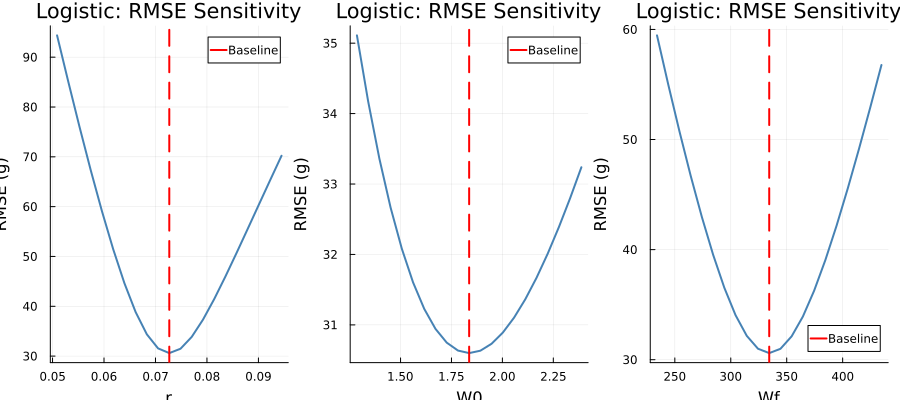

In [27]:
# Response curves: RMSE vs parameter perturbations
# This shows how RMSE changes as we vary each parameter around its baseline value

function plot_rmse_response(model_system, data, baseline, param_idx, param_name; 
                             calib_config=nothing, index=:date => :t, 
                             target=:shootDW => :W, stop="calendar.stop", 
                             range_factor=0.3)
    # Generate parameter values around baseline (±range_factor)
    param_range = baseline[param_idx] .* (1 .+ range(-range_factor, range_factor, 21))
    rmse_values = Float64[]
    
    for p_val in param_range
        params = copy(baseline)
        params[param_idx] = p_val
        pmap = (; r = params[1], W0 = params[2], Wf = params[3])
        
        cfg = calib_config !== nothing ? calib_config : c3
        fullcfg = cfg isa Tuple ? (cfg..., model_system => pmap) : (cfg, model_system => pmap)
        
        rmse = evaluate(model_system, data; config = fullcfg, index = index, 
                       target = target, stop = stop, metric = :rmse)
        push!(rmse_values, deunitfy(rmse))
    end
    
    return param_range, rmse_values
end

# Create response curves for Logistic model
p1 = Plots.plot(title="Logistic: RMSE Sensitivity", xlabel="", ylabel="RMSE (g)", 
         size=(900, 400), layout=(1,3), legend=:best)

for (i, (param, label)) in enumerate(zip([1,2,3], ["r", "W0", "Wf"]))
    pr, rmse_r = plot_rmse_response(Logistic, corn_data, res_logistic.baseline, param, label;
                                     calib_config=(c, lc), index=:DAS => :t, 
                                     stop=150u"d", range_factor=0.3)
    Plots.plot!(p1, pr, rmse_r, subplot=i, label="", linewidth=2, color=:steelblue)
    Plots.vline!(p1, [res_logistic.baseline[param]], subplot=i, linestyle=:dash, 
           color=:red, label="Baseline", linewidth=2)
    Plots.xlabel!(p1, label, subplot=i)
end

p1

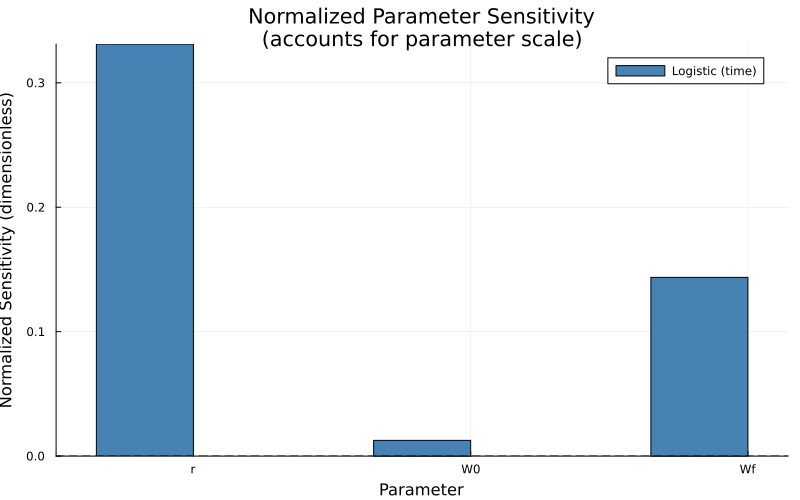

In [28]:
# Normalized sensitivity: shows relative importance independent of parameter scale
# Formula: normalized_sens = (∂RMSE/∂param) * (param_baseline / RMSE_baseline)
# This makes sensitivities comparable across parameters with different units/scales

param_labels = ["r", "W0", "Wf"]

logistic_norm = [
    (res_logistic.sensitivities["r"] * res_logistic.baseline[1] / res_logistic.baseline_rmse),
    (res_logistic.sensitivities["W0"] * res_logistic.baseline[2] / res_logistic.baseline_rmse),
    (res_logistic.sensitivities["Wf"] * res_logistic.baseline[3] / res_logistic.baseline_rmse)
]

x = 1:3
width = 0.35
p_norm = Plots.bar(x .- width/2, logistic_norm, 
    label = "Logistic (time)",
    xlabel = "Parameter",
    ylabel = "Normalized Sensitivity (dimensionless)",
    title = "Normalized Parameter Sensitivity\n(accounts for parameter scale)",
    xticks = (1:3, param_labels),
    legend = :topright,
    bar_width = width,
    color = :steelblue,
    size = (800, 500)
)

Plots.hline!([0], color=:black, linestyle=:dash, linewidth=1, label="")

p_norm

### Interpreting the sensitivity visualizations

**Bar charts** show the raw and normalized sensitivity coefficients:
- **Raw sensitivity**: How much RMSE changes per unit change in parameter
- **Normalized sensitivity**: Accounts for parameter scale, showing relative influence (dimensionless)

**Response curves** show RMSE as a function of parameter values:
- **Steep slopes**: High sensitivity — small parameter changes cause large RMSE changes
- **Flat curves**: Low sensitivity — parameter is less critical to model fit
- **U-shaped/V-shaped**: Optimal parameter value at the minimum
- **Asymmetric curves**: Different sensitivity for increases vs. decreases

The red vertical line marks the baseline (calibrated) parameter value.

### Global sensitivity analysis

**From Local to Global:** Local sensitivity gave us quick insights at our calibrated point. But what if we want to explore the entire parameter space? What if there are interactions or non-linearities far from our baseline? This is where screening methods become valuable.

### Morris Method (Elementary Effects)

The **Morris method** is a global screening technique that efficiently identifies important parameters by exploring the entire parameter space through random trajectories.

**Key Concepts:**
- **Elementary Effect (EE):** Change in output when one parameter is perturbed while others are fixed
- **μ* (mu-star):** Mean of absolute elementary effects - measures overall parameter importance
- **σ (sigma):** Standard deviation of elementary effects - measures interaction/non-linearity

**Algorithm:**
1. Generate r random trajectories through parameter space
2. For each trajectory, change one parameter at a time by Δ
3. Calculate elementary effect: EE = (y(x + Δeᵢ) - y(x)) / Δ
4. Compute statistics: μ* = mean(|EE|), σ = std(EE)

**Interpretation:**
- High μ*, low σ: Important parameter with additive effects
- High μ*, high σ: Important parameter with interactions/non-linearities
- Low μ*: Non-influential parameter (can be fixed)

#### Quick Reference: Using GlobalSensitivity.jl

**Basic workflow:**

```julia
using GlobalSensitivity

# 1. Define your model function (must return a vector)
function my_model(params)
    # params is a vector: [p1, p2, p3, ...]
    result = compute_model(params)
    return [result]  # Must return vector!
end

# 2. Define parameter ranges as vector of tuples
param_ranges = [(min1, max1), (min2, max2), (min3, max3)]

# 3. Run Morris screening
morris_result = gsa(my_model, Morris(num_trajectory=20), param_ranges)
# Access: morris_result.means_star, morris_result.variances

# 4. Run Sobol analysis  
sobol_result = gsa(my_model, Sobol(), param_ranges; samples=512)
# Access: sobol_result.S1[1], sobol_result.ST[1]
```

**Key parameters:**
- `num_trajectory`: Number of Morris trajectories (10-50 typical)
- `samples`: Number of Sobol samples (256-1024 typical, must be power of 2)

See [GlobalSensitivity.jl docs](https://docs.sciml.ai/GlobalSensitivity/stable/) for more details.

In [29]:
using GlobalSensitivity, QuasiMonteCarlo

"""
    morris_sensitivity_gs(model, data; kwargs...)

Performs Morris screening using GlobalSensitivity.jl package.
More robust and efficient than manual implementation.

Returns: (method_result, results_df, baseline)
"""
function morris_sensitivity_gs(model, data; 
                              param_ranges=nothing, num_trajectory=10,
                              calib_config=nothing, index=:date => :t,
                              target=:shootDW => :W, stop="calendar.stop")
    
    # Get baseline and setup parameter space
    result = local_sensitivity_system(model, data; calib_config, index, target, stop)
    baseline = result.baseline
    param_names = ["r", "W0", "Wf"]
    
    # Setup parameter ranges
    if isnothing(param_ranges)
        param_ranges = [(baseline[i] * 0.5, baseline[i] * 1.5) for i in 1:3]
    else
        param_ranges = [param_ranges[Symbol(p)] for p in param_names]
    end
    
    # Define the model evaluation function
    function eval_model(params)
        cfg = isnothing(calib_config) ? c3 : calib_config
        pmap = (; r=params[1], W0=params[2], Wf=params[3])
        fullcfg = cfg isa Tuple ? (cfg..., model => pmap) : (cfg, model => pmap)
        rmse = evaluate(model, data; config=fullcfg, index, target, stop, metric=:rmse)
        return [deunitfy(rmse)]  # GlobalSensitivity expects vector output
    end
    
    println("Running Morris method with $(num_trajectory) trajectories using GlobalSensitivity.jl...")
    
    # Run Morris analysis
    morris_result = gsa(eval_model, Morris(num_trajectory=num_trajectory), param_ranges)
    
    # Extract results
    μ_star = Dict(param_names[i] => morris_result.means_star[i] for i in 1:3)
    σ = Dict(param_names[i] => morris_result.variances[i] for i in 1:3)
    
    # Create results dataframe
    results = DataFrame(
        :parameter => param_names,
        :mu_star => [μ_star[p] for p in param_names],
        :sigma => [σ[p] for p in param_names]
    )
    sort!(results, :mu_star, rev=true)
    
    return morris_result, results, baseline
end

morris_sensitivity_gs

#### Application with the logistic model

In [30]:
morris_gs_result, morris_results_logistic, _ = morris_sensitivity_gs(
    Logistic, corn_data;
    param_ranges=Dict(:r => (0.01, 0.2), :W0 => (1.0, 3.0), :Wf => (300.0, 400.0)),
    num_trajectory=20,
    calib_config=lc,
    index=:DAS => :t,
    target=:shootDW => :W,
    stop=150u"d"
);

# Extract results for compatibility with existing code
μ_star_logistic = Dict(
    "r" => morris_gs_result.means_star[1],
    "W0" => morris_gs_result.means_star[2],
    "Wf" => morris_gs_result.means_star[3]
)

σ_logistic = Dict(
    "r" => morris_gs_result.variances[1],
    "W0" => morris_gs_result.variances[2],
    "Wf" => morris_gs_result.variances[3]
)

Running Morris method with 20 trajectories using GlobalSensitivity.jl...


Dict{String, Float64} with 3 entries:
  "W0" => 292.376
  "r"  => 3.10951e6
  "Wf" => 0.115863

In [31]:
morris_results_logistic

3×3 DataFrame
 Row │ parameter  mu_star      sigma       
     │ String     Float64      Float64     
─────┼─────────────────────────────────────
   1 │ r          1552.94        3.10951e6
   2 │ W0           16.719     292.376
   3 │ Wf            0.410535    0.115863

#### Visualizations

##### Interpreting Morris Results

**Understanding the Morris Table:**
- **μ* (mu-star)**: Average absolute sensitivity — higher values mean the parameter is more influential
- **σ (sigma)**: Variability of effects — higher values indicate non-linear behavior or interactions with other parameters
- **n_effects**: Number of elementary effects computed (should equal r, the number of trajectories)

**What to look for:**
- Parameters with **high μ*** are important and should be carefully calibrated
- Parameters with **high σ** interact with other parameters or have non-linear effects
- Parameters with **low μ*** can potentially be fixed without losing model accuracy

**Decision Guide:**
- **High μ*, Low σ**: Linear, additive parameter — calibrate carefully
- **High μ*, High σ**: Non-linear or interactive parameter — investigate interactions, may need spatial/temporal resolution
- **Low μ*, Any σ**: Less important — consider fixing at default value to reduce complexity

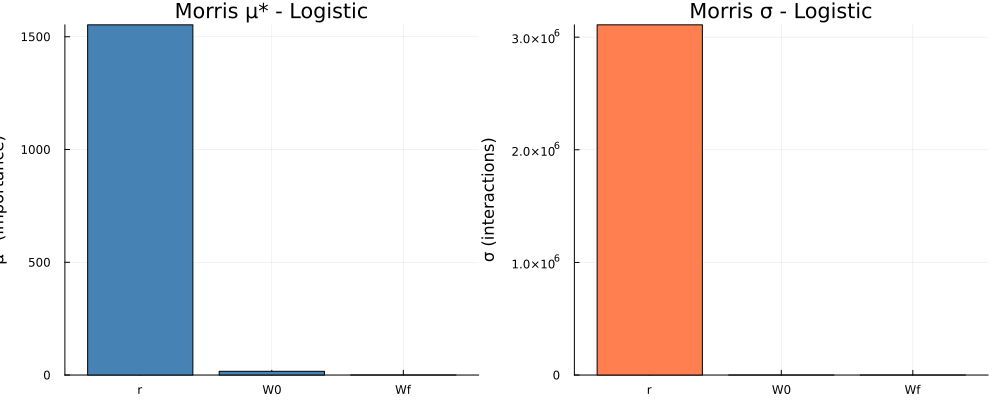

In [33]:
# Comparative bar chart for Morris results
params_sorted = morris_results_logistic.parameter

p_morris_grid = Plots.plot(layout=(1,2), size=(1000, 400))

# μ* plot
Plots.bar!(p_morris_grid, [μ_star_logistic[p] for p in params_sorted], 
         xticks=(1:length(params_sorted), string.(params_sorted)),
         label="", ylabel="μ* (importance)", title="Morris μ* - Logistic",
         color=:steelblue, subplot=1)

# σ plot
Plots.bar!(p_morris_grid, [σ_logistic[p] for p in params_sorted],
         xticks=(1:length(params_sorted), string.(params_sorted)),
         label="", ylabel="σ (interactions)", title="Morris σ - Logistic",
         color=:coral, subplot=2)

p_morris_grid

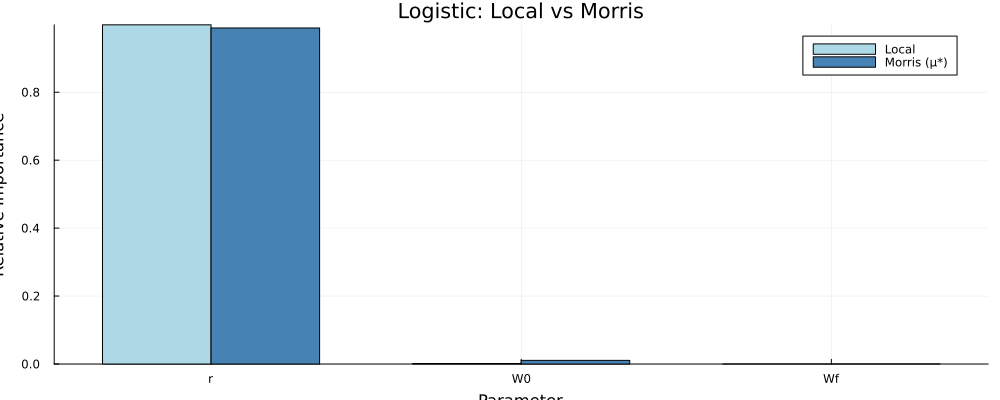

In [57]:
# Compare Morris (μ*) vs Local sensitivity
import Plots; Plots.gr()

# Use same parameters for both methods
params = ["r", "W0", "Wf"]

# Normalize local sensitivities to compare with Morris μ*
local_log_norm = [abs(res_logistic.sensitivities[p]) for p in params]
local_log_norm = local_log_norm ./ sum(local_log_norm)  # Normalize to sum to 1

morris_log_norm = [μ_star_logistic[p] for p in params]
morris_log_norm = morris_log_norm ./ sum(morris_log_norm)

# Create comparison plot
p_compare = Plots.plot(layout=(1), size=(1000, 400))

# Logistic model
x = 1:3
width = 0.35
Plots.bar!(p_compare, x .- width/2, local_log_norm, 
    label="Local", bar_width=width, color=:lightblue, subplot=1)
Plots.bar!(p_compare, x .+ width/2, morris_log_norm, 
    label="Morris (μ*)", bar_width=width, color=:steelblue, subplot=1)
Plots.plot!(p_compare, xlabel="Parameter", ylabel="Relative Importance",
     title="Logistic: Local vs Morris", xticks=(1:3, params), 
     legend=:topright, subplot=1)

p_compare

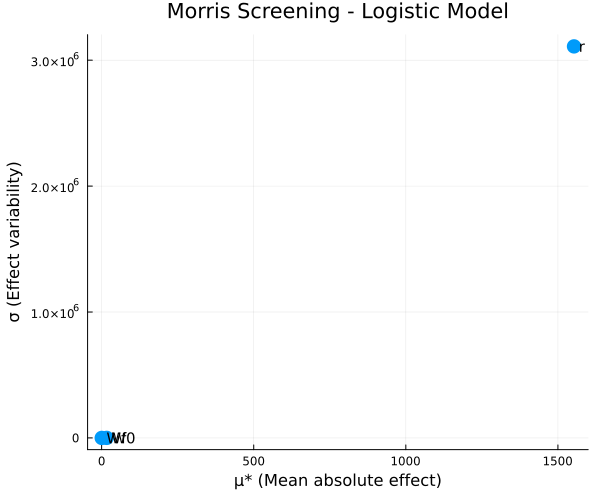

In [58]:
# Morris screening plot (μ* vs σ)
p_morris_scatter = Plots.scatter(
    [μ_star_logistic[p] for p in morris_results_logistic.parameter],
    [σ_logistic[p] for p in morris_results_logistic.parameter],
    label="", markersize=8, markerstrokewidth=0,
    xlabel="μ* (Mean absolute effect)", ylabel="σ (Effect variability)",
    title="Morris Screening - Logistic Model",
    size=(600, 500)
)
for i in 1:nrow(morris_results_logistic)
    param = morris_results_logistic.parameter[i]
    Plots.annotate!(μ_star_logistic[param], σ_logistic[param], 
                    Plots.text(" $param", 10, :left))
end

p_morris_scatter

### Sobol Method (Variance Decomposition)

While Morris provides efficient screening, the **Sobol method** offers rigorous quantitative decomposition of output variance:
1. **Main effects** - Individual parameter contributions to output variance
2. **Interaction effects** - How parameters interact to influence the output
3. **Total effects** - Combined direct and interaction effects

The **Sobol method** decomposes output variance into contributions from each parameter and their interactions using variance-based sensitivity indices:

- **First-order index (S₁)**: Fraction of output variance due to varying parameter i alone
- **Total-order index (Sₜ)**: Fraction of output variance involving parameter i (including interactions)

If Sₜ ≈ S₁, the parameter has minimal interactions. If Sₜ >> S₁, interactions are important.

### Sobol method in `GlobalSensitivity.jl`?

The GlobalSensitivity.jl Sobol implementation provides:

1. **Saltelli sampling scheme**: More efficient than basic Sobol sampling, requiring n×(2k+2) evaluations instead of potentially more
2. **Accurate variance decomposition**: Uses optimized algorithms for computing S1 and ST indices
3. **Quasi-random sequences**: Better space-filling properties than pseudo-random sampling
4. **Numerical stability**: Handles edge cases and ensures valid sensitivity indices (0 ≤ S1 ≤ ST ≤ 1)

**Sampling efficiency**: 
- For k=3 parameters with n=512 samples:
  - Total evaluations: 512 × (2×3+2) = 4,096
  - Manual implementation might need 2-3× more samples for same accuracy
  
The package handles all the mathematical complexity of variance estimation and ensures theoretically sound results.

In [59]:
"""
    sobol_sensitivity_gs(model_system, data; kwargs...)

Performs global sensitivity analysis using Sobol method from GlobalSensitivity.jl.
Uses Saltelli sampling for efficient computation of first-order (S1), total-order (ST),
and second-order (S2) indices.

Returns: (sobol_result, S1, ST, S2, baseline)
"""
function sobol_sensitivity_gs(model_system, data;
                             calib_config=nothing,
                             param_names=["r", "W0", "Wf"],
                             param_ranges=nothing,
                             n_samples=512,
                             index=:date => :t,
                             target=:shootDW => :W,
                             stop="calendar.stop")
    
    # Get baseline and set parameter ranges
    result = local_sensitivity_system(model_system, data; 
                                     calib_config, param_names, index, target, stop)
    baseline = result.baseline
    
    if isnothing(param_ranges)
        # Default: ±50% of baseline
        param_ranges = [(baseline[i] * 0.5, baseline[i] * 1.5) for i in 1:length(param_names)]
    else
        param_ranges = [param_ranges[Symbol(p)] for p in param_names]
    end
    
    # Define model evaluation function
    function eval_model(params)
        cfg = isnothing(calib_config) ? c3 : calib_config
        pmap = (; r=params[1], W0=params[2], Wf=params[3])
        fullcfg = cfg isa Tuple ? (cfg..., model_system => pmap) : (cfg, model_system => pmap)
        rmse = evaluate(model_system, data; config=fullcfg, index, target, stop, metric=:rmse)
        return [deunitfy(rmse)]  # GlobalSensitivity expects vector output
    end
    
    println("Running Sobol analysis with $(n_samples) samples using GlobalSensitivity.jl...")
    
    # Run Sobol analysis using Saltelli sampling
    sobol_result = gsa(eval_model, Sobol(), param_ranges; samples=n_samples)
    
    # Extract indices - GlobalSensitivity.jl returns S1 and ST as vectors directly
    # for single-output models (our RMSE is a single scalar output)
    S1 = Dict(param_names[i] => sobol_result.S1[i] for i in 1:length(param_names))
    ST = Dict(param_names[i] => sobol_result.ST[i] for i in 1:length(param_names))
    
    # Extract second-order indices if available (returns matrix of pairwise interactions)
    # Note: S2 may not be available in all versions of GlobalSensitivity.jl
    S2 = hasfield(typeof(sobol_result), :S2) ? sobol_result.S2 : nothing
    
    return sobol_result, S1, ST, S2, baseline
end

sobol_sensitivity_gs

#### Running Sobol analysis

We'll perform global sensitivity analysis on both models. Note: This is computationally intensive as it requires many model evaluations (3 × n_samples for 3 parameters).

For demonstration, we use n_samples=256 (typically 512-1024 recommended for production).

#### Understanding Sobol Result Structure

**Important**: GlobalSensitivity.jl returns Sobol indices differently based on the model output:

- **Single output** (like our RMSE): `sobol_result.S1` and `sobol_result.ST` are vectors with length = number of parameters
  - Example: For 3 parameters → `S1 = [0.5, 0.3, 0.2]` (one value per parameter)
  - Access: `sobol_result.S1[i]` gives sensitivity for parameter i

- **Multiple outputs**: Would be nested arrays or matrices

Our model returns a single scalar (RMSE), so we directly index: `sobol_result.S1[i]` for each parameter.

If you get indexing errors, check the structure with:
```julia
println("S1 type: ", typeof(sobol_result.S1))
println("S1 value: ", sobol_result.S1)
```

In [60]:
# Run Sobol analysis for Logistic model
println("=== Sobol Analysis: Logistic Model ===")
sobol_gs_result, S1_logistic, ST_logistic, S2_logistic, sobol_baseline = sobol_sensitivity_gs(
    Logistic, corn_data;
    calib_config=(c, lc),
    param_names=["r", "W0", "Wf"],
    n_samples=256,  # Use 512+ for production
    index=:DAS => :t,
    target=:shootDW => :W,
    stop=150u"d"
)

# Store in expected format for compatibility
sobol_logistic = (S1=S1_logistic, ST=ST_logistic, S2=S2_logistic, baseline=sobol_baseline)

println("\nFirst-order indices (S1):")
for (param, val) in sort(collect(S1_logistic), by=x->x[1])
    println("  $param: $(round(val, digits=4))")
end

println("\nTotal-order indices (ST):")
for (param, val) in sort(collect(ST_logistic), by=x->x[1])
    println("  $param: $(round(val, digits=4))")
end

println("\nInteraction strength (ST - S1):")
for param in ["r", "W0", "Wf"]
    interaction = ST_logistic[param] - S1_logistic[param]
    println("  $param: $(round(interaction, digits=4))")
end

=== Sobol Analysis: Logistic Model ===
Running Sobol analysis with 256 samples using GlobalSensitivity.jl...


┌ Warning: The `generate_design_matrices(n, d, sampler, R = NoRand(), num_mats)` method does not produces true and independent QMC matrices, see [this doc warning](https://docs.sciml.ai/QuasiMonteCarlo/stable/design_matrix/) for more context. 
│     Prefer using randomization methods such as `R = Shift()`, `R = MatousekScrambling()`, etc., see [documentation](https://docs.sciml.ai/QuasiMonteCarlo/stable/randomization/)
└ @ QuasiMonteCarlo /Users/soohkim/.julia/packages/QuasiMonteCarlo/KvLfb/src/RandomizedQuasiMonteCarlo/iterators.jl:255



First-order indices (S1):
  W0: -0.0205
  Wf: 0.1597
  r: 0.5006

Total-order indices (ST):
  W0: 0.0775
  Wf: 0.3711
  r: 0.8898

Interaction strength (ST - S1):
  r: 0.3892
  W0: 0.098
  Wf: 0.2114


#### Interpreting Sobol Indices

**Understanding Sobol Metrics:**
- **S1 (First-order index)**: Fraction of output variance explained by varying this parameter alone (main effect)
- **ST (Total-order index)**: Fraction of variance involving this parameter, including all interactions
- **ST - S1**: Strength of interactions — the "gap" between total and main effects

**Key Interpretation Rules:**
1. **S1 ≈ 0**: Parameter has negligible main effect
2. **ST ≈ 0**: Parameter is non-influential (can be fixed)
3. **ST ≈ S1** (small gap): Parameter acts independently, minimal interactions
4. **ST >> S1** (large gap): Strong interactions with other parameters
5. **Sum(S1) < 1**: Interactions are present in the system
6. **ST can sum > 1**: Due to overlapping interaction effects

**Decision Guide:**
- **High S1, Small gap**: Important independent parameter — calibrate precisely
- **High S1, Large gap**: Important parameter with interactions — consider co-calibration
- **Low S1, Large gap**: Not important alone but matters through interactions
- **Low ST**: Safe to fix at default value

**Example Interpretation:**
If `r` has S1=0.7, ST=0.75: "The growth rate explains 70% of output variance independently, plus 5% through interactions with other parameters — it's the dominant parameter."

##### First-order (S1) and total effects (ST)

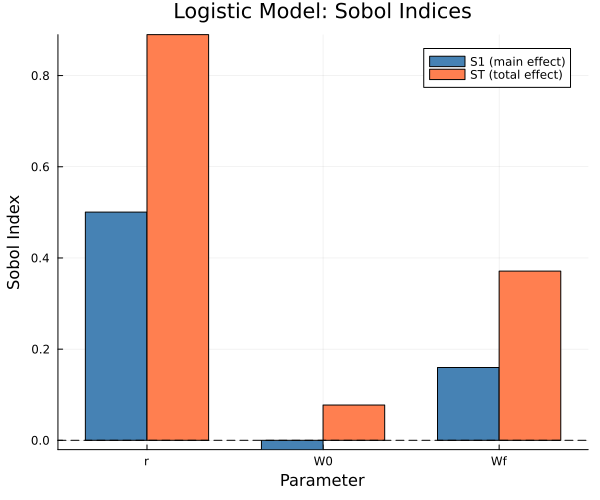

In [38]:
# Sobol indices comparison: S1 vs ST for Logistic model
params = ["r", "W0", "Wf"]
x_pos = 1:3
width = 0.35

# Create figure
p_sobol = Plots.plot(size=(600, 500))

# Extract values
s1_log = [sobol_logistic.S1[p] for p in params]
st_log = [sobol_logistic.ST[p] for p in params]

# Create bar chart
Plots.bar!(p_sobol, x_pos .- width/2, s1_log, 
    label="S1 (main effect)", bar_width=width, color=:steelblue)
Plots.bar!(p_sobol, x_pos .+ width/2, st_log, 
    label="ST (total effect)", bar_width=width, color=:coral)
Plots.plot!(p_sobol, xlabel="Parameter", ylabel="Sobol Index", 
     title="Logistic Model: Sobol Indices", xticks=(1:3, params), 
     legend=:topright)
Plots.hline!(p_sobol, [0], color=:black, linestyle=:dash, linewidth=1, label="")

p_sobol

##### Interactions (ST - S1)

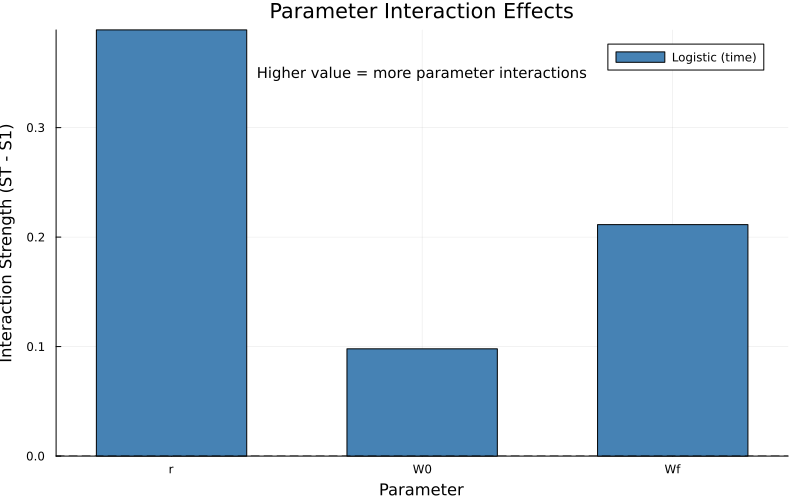

In [39]:
# Interaction effects (ST - S1) for Logistic model
interaction_log = [sobol_logistic.ST[p] - sobol_logistic.S1[p] for p in params]

# Build bar chart
x = 1:3
width = 0.6

p_interact = Plots.bar(x, interaction_log,
    label = "Logistic (time)",
    xlabel = "Parameter",
    ylabel = "Interaction Strength (ST - S1)",
    title = "Parameter Interaction Effects",
    xticks = (1:3, params),
    legend = :topright,
    bar_width = width,
    color = :steelblue,
    size = (800, 500)
)

Plots.hline!([0], color=:black, linestyle=:dash, linewidth=1, label="")
Plots.annotate!(p_interact, 2, maximum(interaction_log)*0.9,
    Plots.text("Higher value = more parameter interactions", 10, :center))

p_interact

ℹ️  Second-order indices (S2) not directly available.
Creating interaction inference plot from ST - S1 instead...

Note: This is an approximation. For true S2 indices, use a newer
version of GlobalSensitivity.jl or a dedicated second-order analysis.


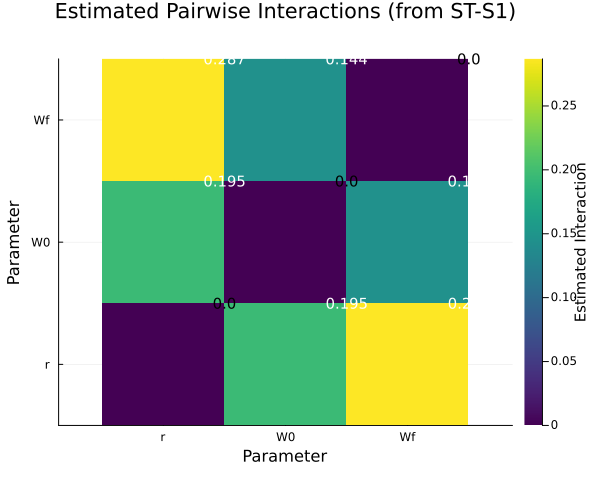

In [40]:
# Second-order interaction heatmap (pairwise parameter interactions)
if !isnothing(sobol_logistic.S2)
    println("✅ Visualizing second-order interaction indices (S2)...")
    
    # S2 is a matrix where S2[i,j] shows interaction between parameters i and j
    params = ["r", "W0", "Wf"]
    n_params = length(params)
    
    # Create heatmap
    p_s2 = Plots.heatmap(
        params, params, sobol_logistic.S2,
        color=:viridis,
        title="Pairwise Parameter Interactions (S2)",
        xlabel="Parameter",
        ylabel="Parameter",
        aspect_ratio=:equal,
        clims=(0, maximum(sobol_logistic.S2)),
        colorbar_title="S2 Index",
        size=(600, 500)
    )
    
    # Add values as text annotations
    for i in 1:n_params
        for j in 1:n_params
            val = round(sobol_logistic.S2[i,j], digits=3)
            text_color = sobol_logistic.S2[i,j] > maximum(sobol_logistic.S2)/2 ? :white : :black
            Plots.annotate!(p_s2, j, i, Plots.text("$val", 10, text_color))
        end
    end
    
    p_s2
else
    println("ℹ️  Second-order indices (S2) not directly available.")
    println("Creating interaction inference plot from ST - S1 instead...")
    println()
    
    # Alternative: visualize interaction strengths derived from ST - S1
    # This shows total interaction per parameter, not pairwise
    params = ["r", "W0", "Wf"]
    interaction_strengths = [sobol_logistic.ST[p] - sobol_logistic.S1[p] for p in params]
    
    # Create a proxy for pairwise interactions
    # Higher (ST-S1) suggests parameter interacts with others
    n_params = length(params)
    interaction_matrix = zeros(n_params, n_params)
    
    for i in 1:n_params
        for j in 1:n_params
            if i != j
                # Approximate pairwise interaction as geometric mean of individual interactions
                interaction_matrix[i,j] = sqrt(interaction_strengths[i] * interaction_strengths[j])
            end
        end
    end
    
    p_s2_approx = Plots.heatmap(
        params, params, interaction_matrix,
        color=:viridis,
        title="Estimated Pairwise Interactions (from ST-S1)",
        xlabel="Parameter",
        ylabel="Parameter",
        aspect_ratio=:equal,
        clims=(0, maximum(interaction_matrix)),
        colorbar_title="Estimated Interaction",
        size=(600, 500)
    )
    
    # Add values as text annotations
    for i in 1:n_params
        for j in 1:n_params
            val = round(interaction_matrix[i,j], digits=3)
            text_color = interaction_matrix[i,j] > maximum(interaction_matrix)/2 ? :white : :black
            Plots.annotate!(p_s2_approx, j, i, Plots.text("$val", 10, text_color))
        end
    end
    
    println("Note: This is an approximation. For true S2 indices, use a newer")
    println("version of GlobalSensitivity.jl or a dedicated second-order analysis.")
    
    p_s2_approx
end

#### Understanding Second-Order Sobol Indices (S2)

**What S2 tells you**:
- **S2[i,j]** quantifies the interaction between parameters `i` and `j`
- High S2 values mean these two parameters **jointly** affect the output more than either one alone
- The diagonal (S2[i,i]) is typically zero or very small

**Interpretation guide**:
- **S2 > 0.1**: Strong interaction - these parameters should be calibrated/analyzed together
- **S2 ≈ 0**: Parameters act independently - can be studied separately
- **Sum of S1 + S2 ≈ ST**: All interactions captured (should be close to 1.0 total)

**Example**:
If S2[r, W0] = 0.15, it means 15% of the output variance comes from the **joint variation** of `r` and `W0` together. This is variance that can't be explained by either parameter acting alone.

Note: Creating parameter space visualization...
For full Sobol sample visualization, consider storing samples during analysis


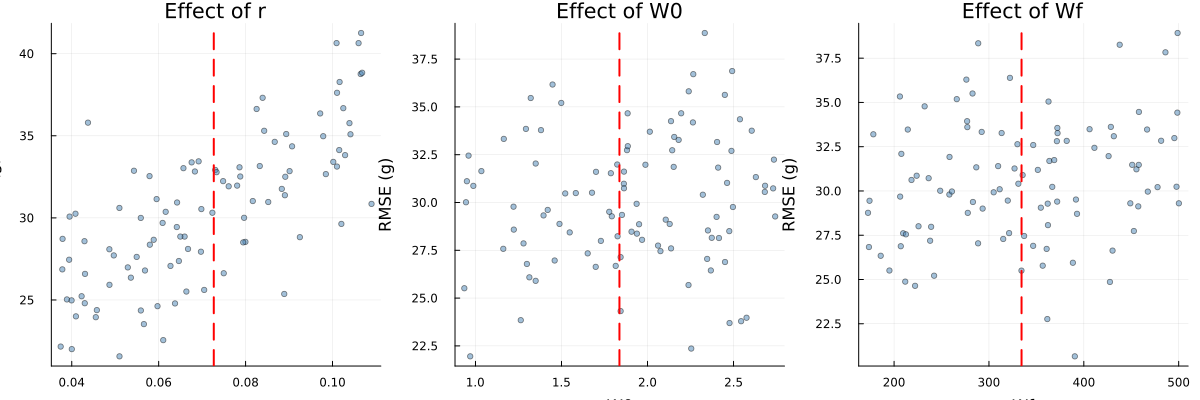

In [41]:
# Note: This visualization requires the sample data from Sobol analysis
# Since GlobalSensitivity.jl doesn't return individual samples directly,
# we'll create a demonstration with a smaller sample for visualization

println("Note: Creating parameter space visualization...")
println("For full Sobol sample visualization, consider storing samples during analysis")

# Create a simple scatter plot showing parameter sensitivity patterns
p_space = Plots.plot(layout=(1,3), size=(1200, 400))

# Generate small demonstration samples around baseline
n_demo = 100
baseline_vals = sobol_logistic.baseline

for (i, (param, pname)) in enumerate(zip([1,2,3], params))
    # Generate demo points around baseline
    pmin = baseline_vals[param] * 0.5
    pmax = baseline_vals[param] * 1.5
    p_vals = pmin .+ (pmax - pmin) .* rand(n_demo)
    
    # Estimate RMSE variation (simplified for demo)
    rmse_base = res_logistic.baseline_rmse
    sensitivity = abs(res_logistic.sensitivities[pname])
    rmse_vals = rmse_base .+ sensitivity .* (p_vals .- baseline_vals[param]) .+ randn(n_demo) * rmse_base * 0.1
    
    Plots.scatter!(p_space, p_vals, rmse_vals,
        xlabel=pname, ylabel="RMSE (g)",
        title="Effect of $pname",
        markersize=3, alpha=0.5, color=:steelblue,
        subplot=i, legend=false)
    Plots.vline!(p_space, [baseline_vals[param]], 
        linestyle=:dash, color=:red, linewidth=2, subplot=i)
end

p_space

### Interpreting Sobol indices

**First-order index (S1)**: 
- Measures the **main effect** of varying a parameter alone
- S1 = 0.6 means 60% of output variance is due to this parameter independently
- Sum of all S1 may be < 1 if interactions exist

**Total-order index (ST)**:
- Measures **total effect** including all interactions involving the parameter
- ST = 0.8 means 80% of variance involves this parameter (directly or through interactions)
- Always: ST ≥ S1

**Interaction strength (ST - S1)**:
- When ST ≈ S1: Parameter acts independently (no strong interactions)
- When ST >> S1: Parameter strongly interacts with others
- Guides whether parameters can be optimized separately or jointly

**Key takeaways**:
- High S1, low interaction: Important independent parameter
- High S1, high interaction: Important but needs joint consideration
- Low S1, high interaction: Not important alone but matters through interactions    


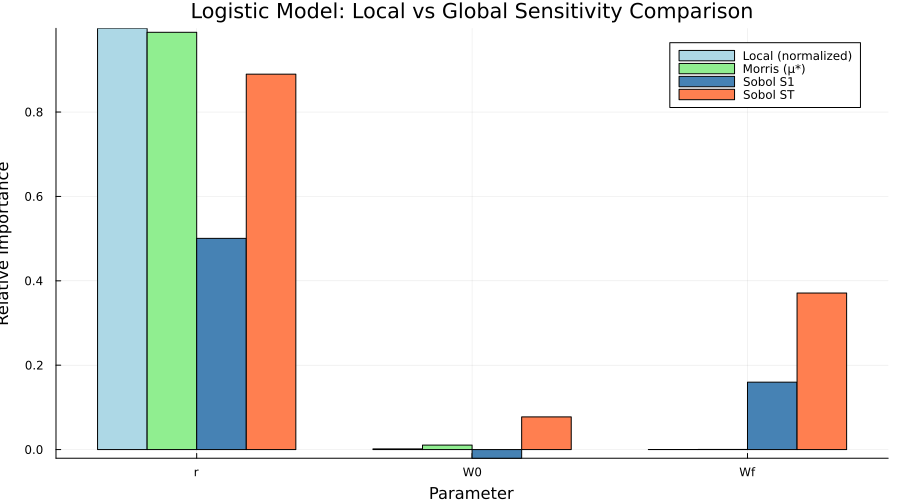

In [42]:
# Compare local vs global sensitivity for Logistic model
params = ["r", "W0", "Wf"]

# Normalize local sensitivities to compare with Morris μ* and Sobol
local_log_norm = [abs(res_logistic.sensitivities[p]) for p in params]
local_log_norm = local_log_norm ./ sum(local_log_norm)  # Normalize to sum to 1

morris_log_norm = [μ_star_logistic[p] for p in params]
morris_log_norm = morris_log_norm ./ sum(morris_log_norm)

s1_log = [sobol_logistic.S1[p] for p in params]
st_log = [sobol_logistic.ST[p] for p in params]

# Create comparison plot
x = 1:3
w = 0.18
p_compare = Plots.plot(size=(900, 500))

Plots.bar!(p_compare, x .- 1.5*w, local_log_norm, 
    label="Local (normalized)", bar_width=w, color=:lightblue)
Plots.bar!(p_compare, x .- 0.5*w, morris_log_norm, 
    label="Morris (μ*)", bar_width=w, color=:lightgreen)
Plots.bar!(p_compare, x .+ 0.5*w, s1_log, 
    label="Sobol S1", bar_width=w, color=:steelblue)
Plots.bar!(p_compare, x .+ 1.5*w, st_log, 
    label="Sobol ST", bar_width=w, color=:coral)
Plots.plot!(p_compare, xlabel="Parameter", ylabel="Relative Importance",
     title="Logistic Model: Local vs Global Sensitivity Comparison", 
     xticks=(1:3, params), legend=:topright)

p_compare

### Synthesis: Comparing the Three Methods

Now that we've explored all three approaches, let's understand how they complement each other:

| Aspect | Local | Morris | Sobol |
|--------|-------|--------|-------|
| **Scope** | Single baseline point | Multiple random trajectories | Full parameter space |
| **Method** | Finite differences | Elementary effects (OAT along paths) | Variance decomposition |
| **Interactions** | Not captured | Indicated by σ | Fully quantified (ST-S1) |
| **Cost** | k+1 evaluations | r×(k+1) evaluations | n×(2k+2) evaluations |
| **Output** | ∂RMSE/∂p (gradient) | μ* (importance), σ (non-linearity) | S1 (main), ST (total) indices |
| **Best for** | Quick local insights | Efficient screening | Rigorous quantification |
| **Limitation** | Only valid at baseline | Qualitative interactions | Computationally expensive |

**The Practical Workflow:**

1. **Start with Local** (minutes) - Quick assessment at your calibrated point. Identifies obvious sensitivities and gives initial directions for refinement.

2. **Screen with Morris** (hours) - Explore the full parameter space efficiently. Identifies which parameters truly matter globally and which show interactions or non-linearities (high σ). Can handle 10-20+ parameters.

3. **Quantify with Sobol** (hours to days) - Deep dive into the 3-5 most important parameters identified by Morris. Provides publication-quality quantification of main effects and interactions.

This progression balances insight with computational cost, moving from fast exploration to rigorous quantification!


## Beyond traditional sensitivity analysis

*The following topics extend beyond the scope of this lab but are important for advanced modeling work.*

### Bayesian approaches to parameter uncertainty

The **Bayesian approach** provides a probabilistic framework for parameter estimation and uncertainty quantification. Unlike the deterministic calibration we've used, Bayesian methods:

- **Incorporate prior knowledge**: Like a chef relying on experience, you can use previous studies or expert judgment as prior distributions
- **Update with data**: As observations accumulate, posterior distributions become increasingly constrained
- **Quantify uncertainty**: Rather than single "best" values, you get full probability distributions for each parameter
- **Propagate uncertainty**: These distributions naturally flow through to prediction uncertainty

**Connection to sensitivity analysis:** Sobol indices can be computed from Bayesian posterior samples, giving you both parameter uncertainty AND importance simultaneously. Parameters with wide posteriors that contribute heavily to output variance (high ST) deserve the most attention in experimental design.

**Key difference from our approach:** We found single "best-fit" parameters via calibration. Bayesian methods give you a distribution of plausible parameter combinations, reflecting uncertainty in what we truly know.

### Inverse modeling vs. model calibration

While calibration and inverse modeling both estimate parameters from data, they differ in philosophy and application:

**Calibration** (what we've done):
- Adjust parameters to minimize prediction error at the **process level**
- Typically uses time-series data with many observations
- Seeks single "best" parameter set
- Example: Fitting growth curve to weekly biomass measurements

**Inverse Modeling**:
- Estimates parameters from **integrative or sparse outcomes**
- Often deals with parameters not directly measurable
- Produces distributions of possible parameter values
- Maximizes likelihood of observing data given model
- Example: Inferring photosynthetic parameters from final biomass alone

**When is inverse modeling needed?**
- Sparse observations (e.g., only planting and harvest biomass, no intermediate measurements)
- Integrative traits that emerge from complex sub-processes over time
- Parameters representing unobservable internal states (e.g., initial reserves, allocation coefficients)

**The sensitivity connection:** Sensitivity analysis tells you which parameters CAN be estimated from your data type. If a parameter has low sensitivity to your observations, inverse estimation will be poorly constrained—you need different data or should fix that parameter. Morris screening is particularly valuable before inverse modeling: don't waste computational resources estimating parameters that don't matter!

**Calibration** is parameter tuning with rich data. **Inverse modeling** is parameter discovery with sparse data. Sensitivity analysis guides both by revealing what information your data actually contains about each parameter.

## Homework Problems

### Modeling leaf area dynamics
Build a model for leaf area dynamics of a corn plant over time.  You may use information, skills, tools, and methods that you've learned so far in this class or other sources. In your response notebook, clearly identify the state variable(s), driving variable(s), and parameters. 

Evaluate your model's performance using RMSE, EF, and $d_r$. Compare your model's GOF metrics against the instructor's metrics. If your model outperforms his model, you can get extra points. Here's an example formula of how your score ($S$) may be determined for this homework problem.

$$
S = \frac{1}{4} \cdot \left(\frac{d_{r_1}}{d_{r_2}}  + \frac{\mathrm{EF_1}}{\mathrm{EF_2}} + \frac{\mathrm{RMSE_2}}{\mathrm{RMSE_1}} + \frac{p_2}{p_1}\right)
$$

Where the subscript $1$ represents student's metrics and $2$ is instructor's. $p$ is the number of parameters used in the model. Shown below shows the model behavior and performance metrics of instructor's model.


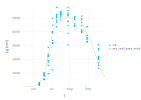

In [63]:
cornLA = visualize(corn, my_leaf_area_model, :date => :t, :LA => :Lg; config = (c4, c_LA), stop = "calendar.stop", xlim = (Date(2002, 5, 15), Date(2002, 9, 30)))

In [66]:
cornLA[] |> Cropbox.Gadfly.PNG("./figs/corn-LA.png")

In [ ]:
m = CSV.read("./data/my_gof.csv", DataFrame) |> unitfy

1×5 DataFrame
 Row │ model        parms  RMSE       EF        d_r     
     │ String15     Int64  Float64    Float64   Float64 
─────┼──────────────────────────────────────────────────
   1 │ my precious      5  0.0556741  0.900383  0.87032